How is the serial ordering of inputs encoded in a linear dynamical system state?

In [1]:
%matplotlib inline
from itertools import product as cprod
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import sys

from disp import set_font_size

DT = .005

R_BIN = np.linspace(0, 1, 17)
R_BIN2 = np.linspace(0, 1, 33)

We start with a binary input stream containing $n$ segments of length $\Delta T$ with $n \Delta T = T$. There are $2^n$ possible input "strings", as each time window can be either $\{0, 1\}$.

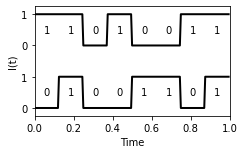

In [2]:
def s2cur(s, step):
    n = len(s)
    
    t = np.arange(0, n*step, DT)
    cur = np.zeros(len(t))
    
    istep = int(round(step/DT))
    
    for istart in s.nonzero()[0]*istep:
        cur[istart:istart+istep] = 1
        
    return cur

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2.25), tight_layout=True)

step = 1/8
ss_xpl = np.array([(0, 1, 0, 0, 1, 1, 0, 1), (1, 1, 0, 1, 0, 0, 1, 1)])

for cs, s in enumerate(ss_xpl):
    cur = s2cur(s, step=step)
    t = np.arange(len(cur)) * DT
    
    ax.plot(t, cur+2*cs, lw=2, c='k')
    for ce, e in enumerate(s):
        ax.text((ce + .5)*step, 2*cs + .5, str(e), ha='center', va='center')
        
ax.set_xlim(0, t[-1]+DT)
ax.set_ylim(-.25, 3.25)
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels([0, 1, 0, 1])
ax.set_xlabel('Time')
ax.set_ylabel('I(t)')

set_font_size(ax, 10)
fig.savefig('plots/s2cur_xpl.pdf')

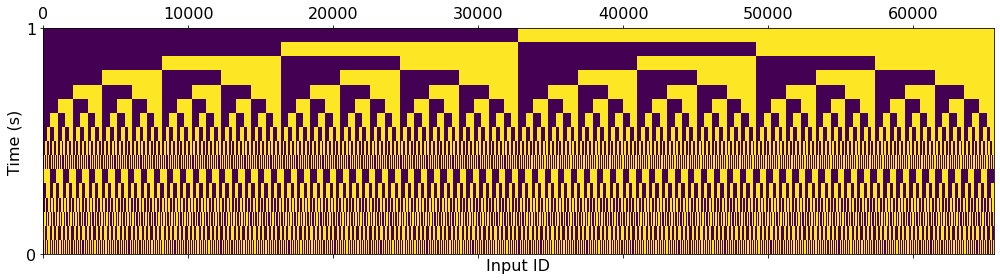

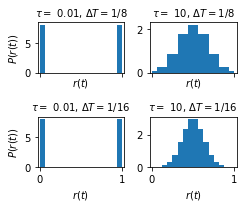

In [4]:
n = 16
ss = np.array(list(cprod((0, 1), repeat=n)))[:, ::-1]
curs = np.array([s2cur(s, step) for s in ss])

fig, ax = plt.subplots(1, 1, figsize=(14, 4), tight_layout=True)
ax.matshow(ss.T, origin='lower', extent=[-1, len(ss), 0, 1])
ax.set_aspect('auto')
ax.set_xlabel('Input ID')
ax.set_ylabel('Time (s)')
set_font_size(ax, 16)

fig, axs = plt.subplots(2, 2, figsize=(3.5, 3), sharex=True, tight_layout=True)

ns = [8, 16]
taus_xpl = [.01, 10]

for ax_row, n in zip(axs, ns):
    
    ss = np.array(list(cprod((0, 1), repeat=n)))[:, ::-1]
    curs = np.array([s2cur(s, step=1/n) for s in ss])
    t = np.arange(len(curs[0])) * DT

    rs = []
    for tau in taus_xpl:
        h = np.exp(-t/tau)
        r = np.array([h[::-1]@cur for cur in curs])
        r /= np.max(r)
        rs.append(r)

    for ax, tau, r in zip(ax_row, taus_xpl, rs):
        ax.hist(r, bins=R_BIN, density=True)
        ax.set_xlim(-.025, 1.025)
        ax.set_xlabel(r'$r(t)$')
        ax.set_title(fr'$\tau = $ {tau}, $\Delta T = 1/${n}')
        
for ax in axs[:, 0]:
    ax.set_ylabel(r'$P(r(t))$')

set_font_size(axs, 10)
fig.savefig('plots/p_r_tau_limits.pdf')

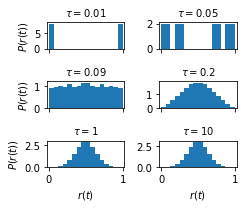

In [5]:
n = 16
ss = np.array(list(cprod((0, 1), repeat=n)))[:, ::-1]
curs = np.array([s2cur(s, step=1/n) for s in ss])
t = np.arange(len(curs[0])) * DT

taus_xpl = [.01, .05, .09, .2, 1, 10]
fig, axs = plt.subplots(3, 2, figsize=(3.5, 3), sharex=True, tight_layout=True)

for ax, tau in zip(axs.flatten(), taus_xpl):
    h = np.exp(-t/tau)
    r = np.array([h[::-1]@cur for cur in curs])
    r /= np.max(r)
    
    ax.hist(r, R_BIN, density=True)
    ax.set_xlim(-.025, 1.025)
    ax.set_title(fr'$\tau = ${tau}')

for ax in axs[-1, :]:
    ax.set_xlabel(r'$r(t)$')
    
for ax in axs[:, 0]:
    ax.set_ylabel(r'$P(r(t))$')

set_font_size(axs, 10)
fig.savefig('plots/p_r_tau_sweep.pdf')

In [6]:
ns = np.array([8, 12, 16, 20])
taus = np.logspace(-2, 1, 61)

ents_all = []

for n in ns:
    ss = np.array(list(cprod((0, 1), repeat=n)))[:, ::-1]
    curs = np.array([s2cur(s, step=1/n) for s in ss])
    t = np.arange(len(curs[0])) * DT
    
    ents = []
    for tau in taus:
        h = np.exp(-t/tau)
        r = np.array([h[::-1]@cur for cur in curs])
        r /= np.max(r)
        
        cts, _ = np.histogram(r, R_BIN, density=True)
        p = cts/np.sum(cts)
        
        ents.append(stats.entropy(p, base=2))
        
    ents_all.append(np.array(ents))

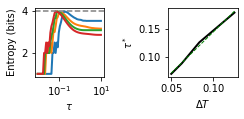

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(3.5, 1.75), tight_layout=True)
for n, ents in zip(ns, ents_all):
    axs[0].semilogx(taus, ents, lw=2)
    
axs[0].axhline(np.log2(len(R_BIN)-1), c='gray', ls='--')
    
axs[0].set_xlabel(r'$\tau$')
axs[0].set_ylabel('Entropy (bits)')

tau_stars = np.array([taus[np.argmax(ents)] for ents in ents_all])
axs[1].plot(1/ns, tau_stars, c='k', lw=2)
axs[1].plot(1/ns, 1/ns/np.log(2), c='g', lw=1, ls='--')

axs[1].set_xlabel(r'$\Delta T$')
axs[1].set_ylabel(r'$\tau^*$')

set_font_size(axs, 10)

fig.savefig('plots/ent_vs_tau.pdf')

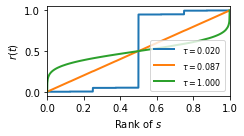

In [7]:
n = 16
ss = np.array(list(cprod((0, 1), repeat=n)))[:, ::-1]
curs = np.array([s2cur(s, step=1/n) for s in ss])
t = np.arange(len(curs[0])) * DT
    
taus_xpl = [.02, .087, 1]

fig, ax = plt.subplots(1, 1, figsize=(3.5, 2), tight_layout=True)
idxs_ranked = []

for tau in taus_xpl:
    h = np.exp(-t/tau)
    r = np.array([h[::-1]@cur for cur in curs])
    r /= np.max(r)
    
    idxs_ranked.append(np.argsort(r))
    ax.plot(np.arange(len(r))/len(r), sorted(r), lw=2)

ax.set_xlim(0, 1)
ax.set_xlabel(r'Rank of $s$')
ax.set_ylabel(r'$r(t)$')
ax.legend([rf'$\tau = ${tau:.3f}' for tau in taus_xpl])

set_font_size(ax, 10, legend_font_size=8)
fig.savefig('plots/r_vs_rank_s.pdf')

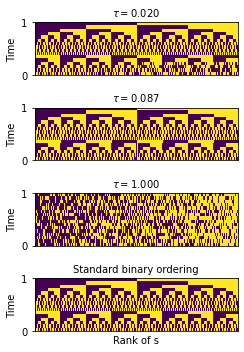

In [8]:
fig, axs = plt.subplots(len(taus_xpl)+1, 1, figsize=(3.5, len(taus_xpl)+2), sharex=True, sharey=True, tight_layout=True)

for ax, tau, idx_ranked in zip(axs, taus_xpl, idxs_ranked):
    ax.matshow(ss[idx_ranked].T, origin='lower', extent=[0, 1, 0, 1])
    ax.set_aspect('auto')
    ax.set_title(rf'$\tau = ${tau:.3f}')

axs[-1].matshow(ss.T, origin='lower', extent=[0, 1, 0, 1])
axs[-1].set_aspect('auto')
axs[-1].set_xlabel('Rank of s')
axs[-1].set_title('Standard binary ordering')

for ax in axs:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_xticks([])
    ax.set_ylabel('Time')
set_font_size(axs, 10)

fig.savefig('plots/sorted_s_vs_tau.pdf')

Repeat response distribution analysis for more time bins of same length (i.e. longer total duration)

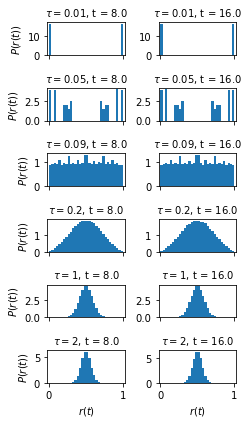

In [24]:
n_in = 200000

ns = [128, 256]
taus_xpl = [.01, .05, .09, .2, 1, 2]
step = 1/16

fig, axs = plt.subplots(6, 2, figsize=(3.5, 6), sharex=True, tight_layout=True)

for cn, n in enumerate(ns):
    ss = np.concatenate([np.random.rand(n_in, n) < .5, np.ones((1, n), bool)])
    curs = np.array([s2cur(s, step=step) for s in ss])
    t = np.arange(len(curs[0])) * DT
    
    for ctau, tau in enumerate(taus_xpl):

        h = np.exp(-t/tau)
        r = np.array([h[::-1]@cur for cur in curs])
        r /= np.max(r)
        
        ax = axs[ctau, cn]
        
        ax.hist(r, R_BIN2, density=True)
        ax.set_xlim(-.025, 1.025)
        ax.set_title(fr'$\tau = ${tau}, t = {step*n}')

for ax in axs[-1, :]:
    ax.set_xlabel(r'$r(t)$')
    
for ax in axs[:, 0]:
    ax.set_ylabel(r'$P(r(t))$')

set_font_size(axs, 10)
fig.savefig('plots/p_r_tau_sweep_vary_n.pdf')

Now vary the bit probability

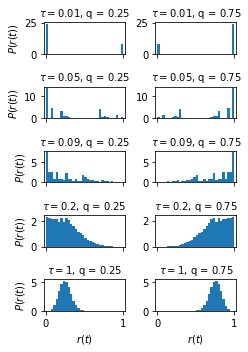

In [28]:
n_in = 200000
n = 128
qs = [.25, .75]

taus_xpl = [.01, .05, .09, .2, 1]
step = 1/16

fig, axs = plt.subplots(5, 2, figsize=(3.5, 5), sharex=True, tight_layout=True)

for cq, q in enumerate(qs):
    ss = np.concatenate([np.random.rand(n_in, n) < q, np.ones((1, n), bool)])
    curs = np.array([s2cur(s, step=step) for s in ss])
    t = np.arange(len(curs[0])) * DT
    
    for ctau, tau in enumerate(taus_xpl):

        h = np.exp(-t/tau)
        r = np.array([h[::-1]@cur for cur in curs])
        r /= np.max(r)
        
        ax = axs[ctau, cq]
        
        ax.hist(r, R_BIN2, density=True)
        ax.set_xlim(-.025, 1.025)
        ax.set_title(fr'$\tau = ${tau}, q = {q}')

for ax in axs[-1, :]:
    ax.set_xlabel(r'$r(t)$')
    
for ax in axs[:, 0]:
    ax.set_ylabel(r'$P(r(t))$')

set_font_size(axs, 10)
fig.savefig('plots/p_r_tau_sweep_vary_q.pdf')

Response entropy vs tau for different $q$.

In [50]:
n = 128
step = 1/16

n_in = 200000
qs = np.array([.5, .25, .1, .05])
taus = np.logspace(-2, 1, 61)

ents_all = []

for q in qs:
    sys.stdout.write(f'q={q}')
    ss = np.concatenate([np.random.rand(n_in, n) < q, np.ones((1, n), bool)])
    curs = np.array([s2cur(s, step=step) for s in ss])
    t = np.arange(len(curs[0])) * DT
    
    ents = []
    for tau in taus:
        sys.stdout.write('.')
        h = np.exp(-t/tau)
        r = np.array([h[::-1]@cur for cur in curs])
        r /= np.max(r)
        
        cts, _ = np.histogram(r, R_BIN, density=True)
        p = cts/np.sum(cts)
        
        ents.append(stats.entropy(p, base=2))
    
    ents_all.append(np.array(ents))
    print('') 

q=0.5.............................................................
q=0.25.............................................................
q=0.1.............................................................
q=0.05.............................................................


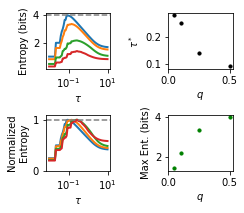

In [65]:
fig, axs = plt.subplots(2, 2, figsize=(3.5, 3), tight_layout=True)
for q, ents in zip(qs, ents_all):
    axs[0, 0].semilogx(taus, ents, lw=2)
    
axs[0, 0].axhline(np.log2(len(R_BIN)-1), c='gray', ls='--')
axs[0, 0].set_xlabel(r'$\tau$')
axs[0, 0].set_ylabel('Entropy (bits)')

for q, ents in zip(qs, ents_all):
    axs[1, 0].semilogx(taus, ents/np.max(ents), lw=2)
    
axs[1, 0].axhline(1, c='gray', ls='--')
axs[1, 0].set_ylim(0, 1.1)
axs[1, 0].set_yticks([0, 1])
axs[1, 0].set_xlabel(r'$\tau$')
axs[1, 0].set_ylabel('Normalized\nEntropy')

tau_stars = np.array([taus[np.argmax(ents)] for ents in ents_all])
axs[0, 1].scatter(qs, tau_stars, c='k', s=10)
axs[0, 1].set_xlim(left=0)

axs[0, 1].set_xlabel(r'$q$')
axs[0, 1].set_ylabel(r'$\tau^*$')

max_ents = np.array([np.max(ents) for ents in ents_all])
axs[1, 1].scatter(qs, max_ents, c='g', s=10)
axs[1, 1].set_xlim(left=0)

axs[1, 1].set_xlabel(r'$q$')
axs[1, 1].set_ylabel(r'Max Ent. (bits)')

set_font_size(axs, 10)
fig.savefig('plots/ent_vs_tau_vs_q.pdf')

In [52]:
for q, tau in zip(qs, tau_stars):
    print(q, tau)

0.5 0.08912509381337459
0.25 0.14125375446227548
0.1 0.25118864315095807
0.05 0.2818382931264455


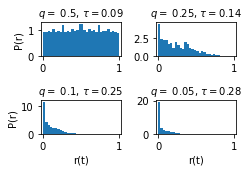

In [71]:
fig, axs = plt.subplots(2, 2, figsize=(3.5, 2.5), tight_layout=True)

for ax, q, tau in zip(axs.flatten(), qs, tau_stars):
    ss = np.concatenate([np.random.rand(n_in, n) < q, np.ones((1, n), bool)])
    curs = np.array([s2cur(s, step=step) for s in ss])
    t = np.arange(len(curs[0])) * DT
    
    h = np.exp(-t/tau)
    r = np.array([h[::-1]@cur for cur in curs])
    r /= np.max(r)

    ax.hist(r, R_BIN2, density=True)
    ax.set_xlim(-.025, 1.025)
    ax.set_title(fr'$q =$ {q}, $\tau = ${tau:.2f}')
    
for ax in axs[:, 0]:
    ax.set_ylabel('P(r)')

for ax in axs[-1, :]:
    ax.set_xlabel('r(t)')
    
set_font_size(axs, 10)
fig.savefig('plots/p_r_q_tau_star.pdf')